In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import kde
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erfinv
from matplotlib.colors import LogNorm

smallFiles = False

#settings
plt.style.use('fast')
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 3.0
matplotlib.rcParams['hist.bins'] = 'auto'
matplotlib.rcParams['text.usetex'] = 'true'
matplotlib.rcParams['image.cmap'] = 'RdYlBu_r' #'hot'
#print(matplotlib.rcParams)

#Common offset for ACP80 runs
gonio_zero = 1570840.0/1000. #mrad
thetaInx_bias = 0.005  #mrad : difference between nominal '0' and crystal plane '0'

#useful labels
d0xL=r"$d_0^{x}$ [mm]"
d0yL=r"$d_0^{y}$ [mm]"
tInXL=r"$\theta_{in}^{x}$ [mrad]"
tInYL=r"$\theta_{in}^{y}$ [mrad]"
tOutXL=r"$\theta_{out}^{x}$ [mrad]"
tOutYL=r"$\theta_{out}^{y}$ [mrad]"
dtL=r"$\Delta\theta_{(out-in)}$ [mrad]"

#useful binning/range
d0xR=[-2.,2.]
d0yR=[-2.,2.]
tInXR=[-0.1,0.1]
tInYR=[-0.1,0.1]
tOutXR=[-0.2,0.2]
tOutXGonioR=[-0.15-gonio_zero,+0.15-gonio_zero]
tOutYR=[-0.1,0.1]
#
nBd0=20
nBth=20
nBd0F=50
nBthF=50


print("Hello world!")
folder= "../BigDataFiles/"
inputFile=folder+"ACP80_0_flt.dat" #"flt" means filtered: particles not entering (in d0X,d0y) the crystal are removed
inputSimFile=folder+"ACP80_min50_flt.dat" #"ACP80_min90_flt.dat"
if (smallFiles):
    folder= "../DataFiles/"
    inputFile=folder+"ACP80_0_p100k.dat"
    inputSimFile=folder+"ACP80_plus70_p100k.dat"

inFileLabel="CH: "+inputFile.split("/")[-1].split("_")[1]
inSimFileLabel="VR: "+inputSimFile.split("/")[-1].split("_")[1]

cols=["gonio_angle","d0_x","d0_y","thetaIn_x","thetaOut_x","thetaIn_y","thetaOut_y","unknown1","unknown2"]


Hello world!


In [2]:
def emittanceRMS(x,y):
    rmsX = np.std(x)
    rmsY = np.std(y)
    #print(np.corrcoef(x,y))
    det = np.linalg.det(np.corrcoef(x,y))
    #print(rmsX,rmsY,det)
    return rmsX*rmsY*math.sqrt(det)
    
def fracToSigma(f):
    return erfinv(f)*math.sqrt(2.)
def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
def GaussFunc(x,A,mu,sigma):
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))/(np.sqrt(2*math.pi)*sigma))

def plot2D(ax,x,y,xlabel,ylabel,bins,rng,cmap):
    plot= ax.hist2d(x, y, bins=bins,range=rng,  cmap=cmap)
    ax.set_xlabel(xlabel, fontsize='20')
    ax.set_ylabel(ylabel, fontsize='20')
    return ax

def plot1D(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    if log: ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng)
    ax.legend(loc= "best")
    ax.grid(True)
    return ax

def plot1DNorm(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng, density=True)
    ax.legend(loc= "lower right")
    ax.grid(True)
    return ax

In [4]:
datasetI = pd.read_csv(inputFile,header=None,names=cols)
datasetI["gonio_angle"]=datasetI["gonio_angle"]/1000.
datasetI["thetaIn_x"]=datasetI["thetaIn_x"]*1000.
datasetI["thetaOut_x"]=datasetI["thetaOut_x"]*1000.
datasetI["thetaIn_y"]=datasetI["thetaIn_y"]*1000.
datasetI["thetaOut_y"]=datasetI["thetaOut_y"]*1000.
datasetI["deltaTheta"] = datasetI["thetaOut_x"]-datasetI["thetaIn_x"]
datasetI["deltaGonio"] = datasetI["gonio_angle"]-gonio_zero

print(datasetI.iloc[0,:])

if inputSimFile == "":
    datasetSimuI = datasetI
else :
    datasetSimuI = pd.read_csv(inputSimFile,header=None,names=cols)
    datasetSimuI["gonio_angle"]=datasetSimuI["gonio_angle"]/1000.
    datasetSimuI["thetaIn_x"]=datasetSimuI["thetaIn_x"]*1000.
    datasetSimuI["thetaOut_x"]=datasetSimuI["thetaOut_x"]*1000.
    datasetSimuI["thetaIn_y"]=datasetSimuI["thetaIn_y"]*1000.
    datasetSimuI["thetaOut_y"]=datasetSimuI["thetaOut_y"]*1000.
    datasetSimuI["deltaTheta"] = datasetSimuI["thetaOut_x"]-datasetSimuI["thetaIn_x"]
    datasetSimuI["deltaGonio"] = datasetSimuI["gonio_angle"]-gonio_zero
    if inputSimFile==folder+"ACP80_min70_flt.dat":
        datasetSimuI["deltaGonio"] = datasetSimuI["deltaGonio"]-3252.2186 #3252.0786

    print(datasetSimuI.iloc[0,:])

gonio_angle    1570.840000
d0_x             -0.118649
d0_y             -0.246366
thetaIn_x        -0.007750
thetaOut_x        0.049916
thetaIn_y         0.018783
thetaOut_y        0.039124
unknown1          0.000000
unknown2          0.000000
deltaTheta        0.057666
deltaGonio        0.000000
Name: 0, dtype: float64
gonio_angle    1570.790000
d0_x             -0.693842
d0_y             -1.434139
thetaIn_x        -0.000333
thetaOut_x       -0.009331
thetaIn_y        -0.001583
thetaOut_y        0.003948
unknown1          0.000000
unknown2          0.000000
deltaTheta       -0.008998
deltaGonio       -0.050000
Name: 0, dtype: float64


In [5]:
#pass the initial dataset to the one you'll manipulate
dataset = datasetI

#define weights
dataset["weight"] = 1.

#pass the initial dataset to the one you'll manipulate
datasetSimu = datasetSimuI

#define weights
datasetSimu["weight"] = 1.

## Now we make some plot to have a first glance at the distribution

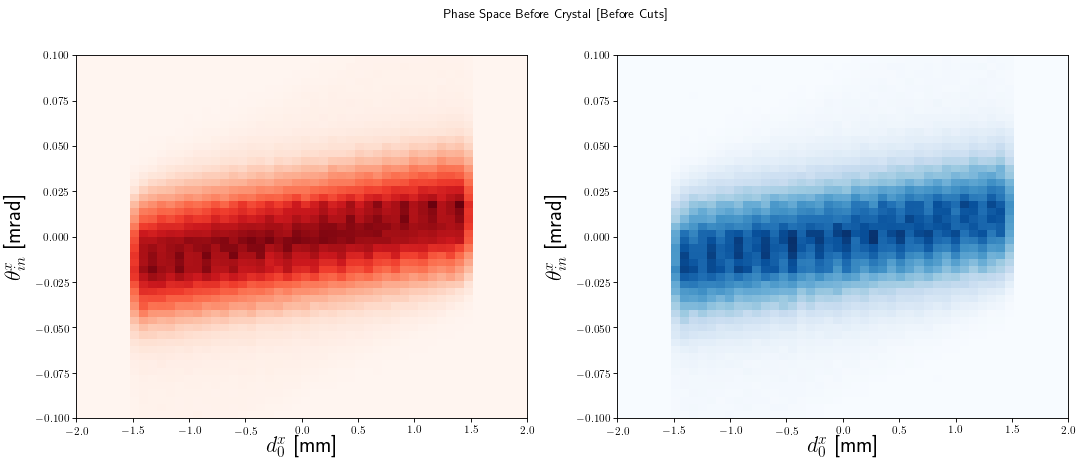

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Phase Space Before Crystal [Before Cuts]")
plot2D(axes[0],
       dataset["d0_x"],
       dataset["thetaIn_x"],
       d0xL,
       tInXL,
       (nBd0F,nBthF),
       [d0xR,tInXR],
       "Reds"
      )
plot2D(axes[1],
       datasetSimu["d0_x"],
       datasetSimu["thetaIn_x"],
       d0xL,
       tInXL,
       (nBd0F,nBthF),
       [d0xR,tInXR],
       "Blues"
      )

plt.show()

## Let's have a look at particle deflection due to the crystal

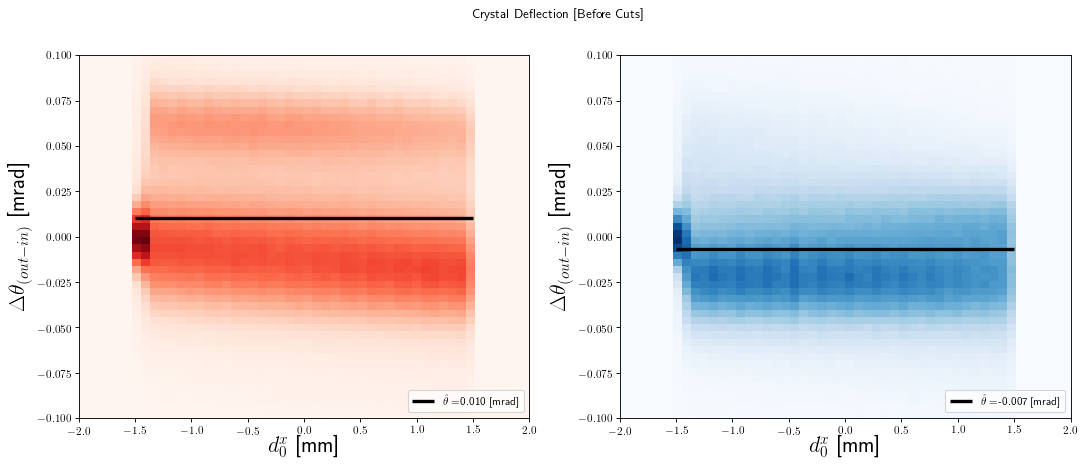

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Crystal Deflection [Before Cuts]")
plotR= plot2D(axes[0],
       dataset["d0_x"],
       dataset["deltaTheta"],
       d0xL,
       dtL,
       (nBd0F,nBthF),
       [d0xR,[-0.1,0.1]],
       "Reds"
      )
mediaR=np.mean(dataset["deltaTheta"])
plotR.hlines(mediaR, np.min(dataset["d0_x"]), np.max(dataset["d0_x"]), label=(r"$\hat\theta=${:.3f} [mrad]".format(mediaR)))
plotR.legend(loc= "lower right")


plotB=plot2D(axes[1],
       datasetSimu["d0_x"],
       datasetSimu["deltaTheta"],
       d0xL,
       dtL,
       (50,50),
       [d0xR,[-0.1,0.1]],
       "Blues"
      )
mediaB=np.mean(datasetSimu["deltaTheta"])
plotB.hlines(mediaB, np.min(datasetSimu["d0_x"]), np.max(datasetSimu["d0_x"]), label=(r"$\hat\theta=${:.3f} [mrad]".format(mediaB)))
plotB.legend(loc= "lower right")

plt.show()

### Let's add some cuts!
    - In the incoming angle in order to choose particles that are going to be channeled (Crit. angle for this 180GeV case is +-15urad: general formula is sqrt(4/E[GeV])*100urad )
    - In x (raw cut on data was +- 1.5mm), we can reduce the data sample to those within +- 1mm
    - In y since we want to avoid problems related with the crystal torsion   
## We have now only particles entering within +-ThetaCrit
    

In [8]:
applyCut = True
applyWeight = False
max_d0x = 1.
max_d0y = 2.
max_thetaInx = 0.015 #15urad

if applyCut:
    dataset = dataset[abs(dataset.d0_x)<max_d0x]
    dataset = dataset[abs(dataset.d0_y)<max_d0y]
    dataset = dataset[abs(dataset.thetaIn_x)+thetaInx_bias<max_thetaInx]
    datasetSimu = datasetSimu[abs(datasetSimu.d0_x)<max_d0x]
    datasetSimu = datasetSimu[abs(datasetSimu.d0_y)<max_d0y]
    datasetSimu = datasetSimu[abs(datasetSimu.thetaIn_x)<max_thetaInx]


## Let's look again at the phase space after these cuts

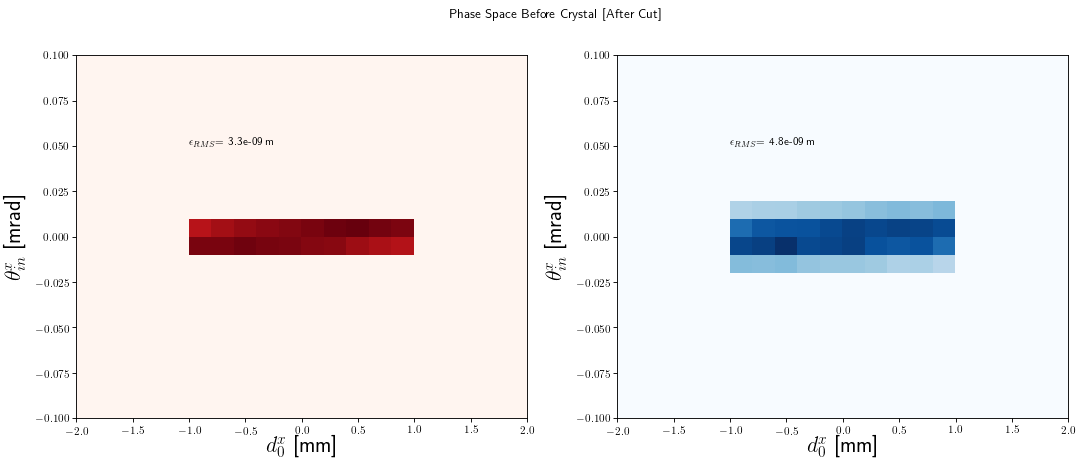

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80, facecolor = "w", edgecolor = "k")
plotR=plot2D(axes[0],dataset["d0_x"],dataset["thetaIn_x"],d0xL,tInXL,
       (nBd0,nBth),[d0xR,tInXR],"Reds")
plotR.text(-1.,.05,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(dataset["d0_x"],dataset["thetaIn_x"])))

plotB=plot2D(axes[1],datasetSimu["d0_x"],datasetSimu["thetaIn_x"],d0xL,tInXL,
       (nBd0,nBth),[d0xR,tInXR],"Blues")
plotB.text(-1.,.05,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaIn_x"])))



fig.suptitle("Phase Space Before Crystal [After Cut]")

plt.show()
#print("Emittance (RMS): ",emittanceRMS(dataset["d0_x"],dataset["thetaIn_x"]),
#    " - ",emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaIn_x"]))

## Let's have a look at some plots to better understand the distribution after the cuts

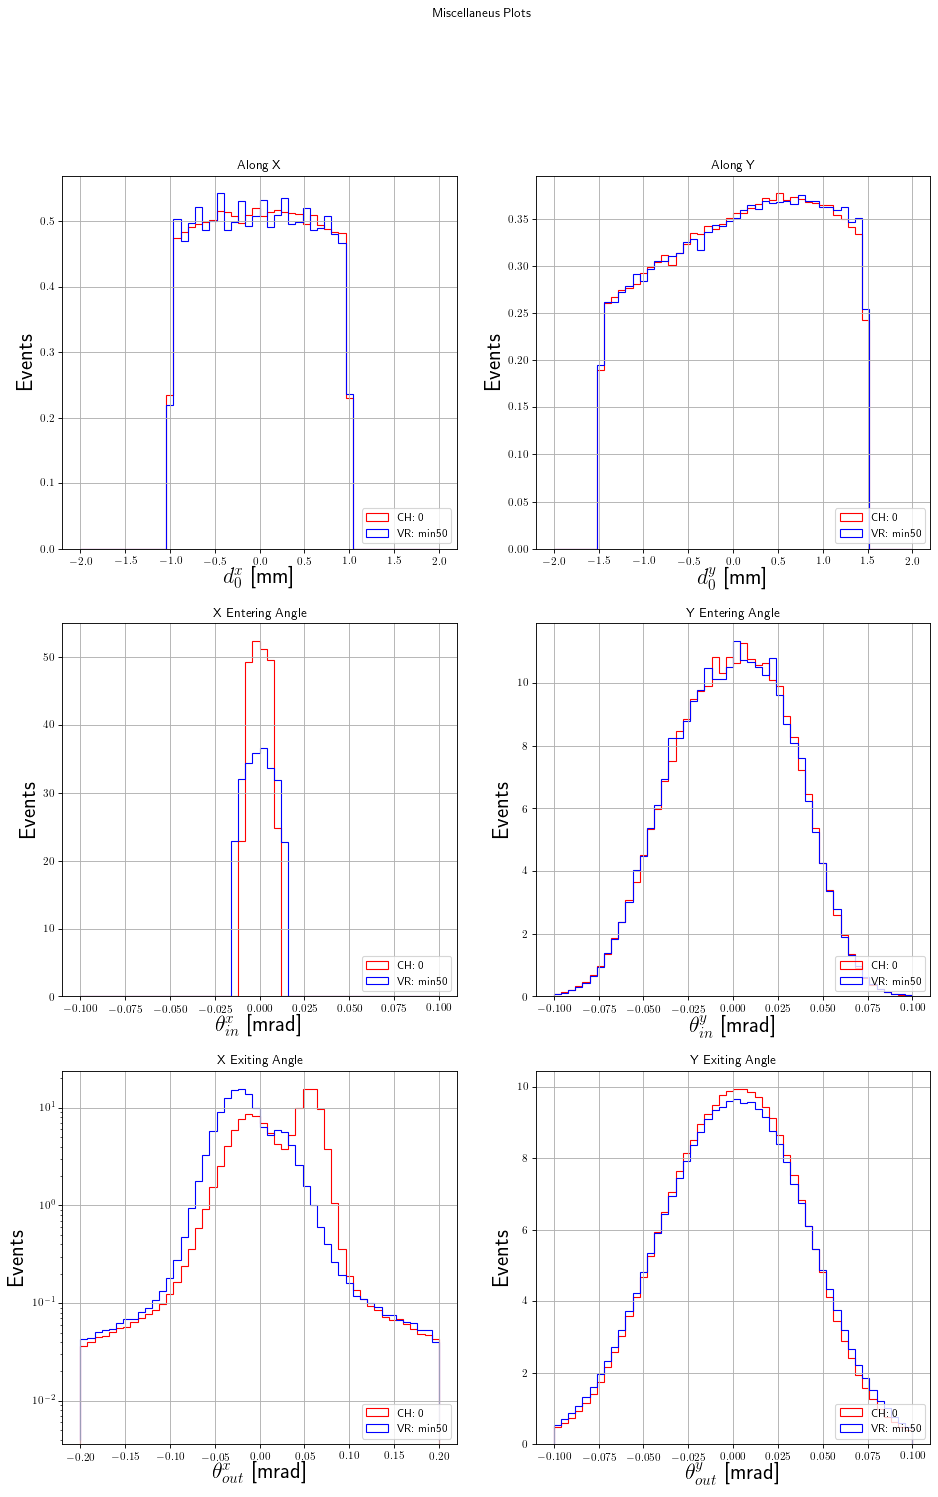

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(7*2, 7*3),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Miscellaneus Plots")

axes[0][0].set_title("Along X")
axes[0][1].set_title("Along Y")
axes[1][0].set_title("X Entering Angle")
axes[1][1].set_title("Y Entering Angle")
axes[2][0].set_title("X Exiting Angle")
axes[2][1].set_title("Y Exiting Angle")


plot1DNorm(axes[0][0],dataset["d0_x"],inFileLabel,d0xL,"Events",
       False,'r',nBd0F,d0xR)
plot1DNorm(axes[0][0],datasetSimu["d0_x"],inSimFileLabel,d0xL,"Events",
       False,'b',nBd0F,d0xR)

plot1DNorm(axes[0][1],dataset["d0_y"],inFileLabel,d0yL,"Events",
       False,'r',nBd0F,d0yR)
plot1DNorm(axes[0][1],datasetSimu["d0_y"],inSimFileLabel,d0yL,"Events",
       False,'b',nBd0F,d0yR)

plot1DNorm(axes[1][0],dataset["thetaIn_x"],inFileLabel,tInXL,"Events",
       False,'r',nBthF,tInXR)
plot1DNorm(axes[1][0],datasetSimu["thetaIn_x"],inSimFileLabel,tInXL,"Events",
       False,'b',nBthF,tInXR)

plot1DNorm(axes[1][1],dataset["thetaIn_y"],inFileLabel,tInYL,"Events",
       False,'r',nBthF,tInYR)
plot1DNorm(axes[1][1],datasetSimu["thetaIn_y"],inSimFileLabel,tInYL,"Events",
       False,'b',nBthF,tInYR)

plot1DNorm(axes[2][0],dataset["thetaOut_x"],inFileLabel,tOutXL,"Events",
       True,'r',nBthF,tOutXR)
plot1DNorm(axes[2][0],datasetSimu["thetaOut_x"],inSimFileLabel,tOutXL,"Events",
       True,'b',nBthF,tOutXR)

plot1DNorm(axes[2][1],dataset["thetaOut_y"],inFileLabel,tOutYL,"Events",
       False,'r',nBthF,tOutYR)
plot1DNorm(axes[2][1],datasetSimu["thetaOut_y"],inSimFileLabel,tOutYL,"Events",
       False,'b',nBthF,tOutYR)

plt.show()


## Now we want to evaluate the efficiency (in terms of number of particles) of the two processes:
    - Channeling (red)
    - Volume Reflection (blue)

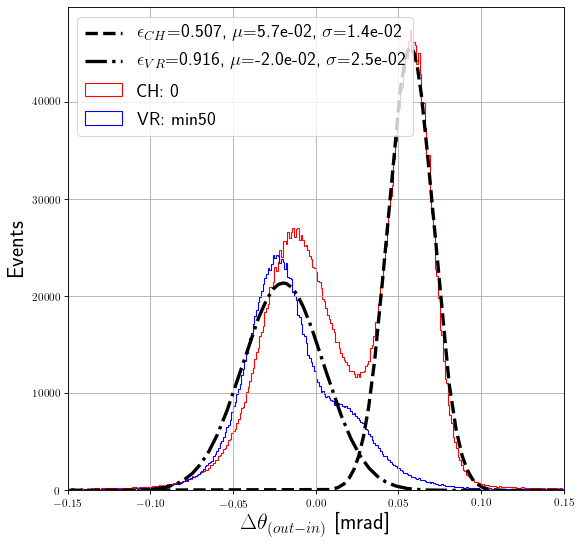

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 165
    # data points      = 40
    # variables        = 3
    chi-square         = 67347018.2
    reduced chi-square = 1820189.68
    Akaike info crit   = 579.459589
    Bayesian info crit = 584.526228
[[Variables]]
    amplitude:  1582.66705 +/- 16.2102074 (1.02%) (init = 1)
    center:     0.05740908 +/- 1.3901e-04 (0.24%) (init = 0)
    sigma:      0.01384927 +/- 1.8456e-04 (1.33%) (init = 1)
    fwhm:       0.03261253 +/- 4.3461e-04 (1.33%) == '2.3548200*sigma'
    height:     45590.3447 +/- 364.154849 (0.80%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.801
    C(center, sigma)     =  0.210
    C(amplitude, center) =  0.203
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 200
    # variables 

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 8),dpi=80,facecolor='w', edgecolor='k')

commonBinWidth=0.001

plot1D(ax,dataset["deltaTheta"],inFileLabel,dtL,"Events",
        False,'r',int(0.5/commonBinWidth),[-0.25,0.25])
plot1D(ax,datasetSimu["deltaTheta"],inSimFileLabel,dtL,"Events",
        False,'b',int(0.5/commonBinWidth),[-0.25,0.25])


if True:
    from lmfit.models import GaussianModel

    mod = GaussianModel()
    modSimu = GaussianModel()

#    mod.set_param_hint('sigma', min=0, max=0.018, value = 0.016, vary = True)
#    mod.set_param_hint('amplitude', min=1000, value = 2200)
#    mod.set_param_hint('center', min=0.056, max=0.1, value = 0.06, vary = True)

    data_entries, bins = np.histogram(dataset[abs(dataset.deltaTheta-0.055)<0.02]["deltaTheta"], bins=int(0.04/commonBinWidth))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    pars = mod.guess(data_entries, x=data_entries)
    out = mod.fit(data_entries.astype(float), x=binscenters.astype(float))
    predicted = out.eval(x=np.linspace(-.3, .3, 1000))
    plt.plot(np.linspace(-.3, .3, 1000), predicted, 'k--', label=(r"$\epsilon_{{CH}}$={:.3f}, $\mu$={:.1e}, $\sigma$={:.1e}".format(((out.params['amplitude'].value)/commonBinWidth/(len(dataset["deltaTheta"]))), out.params['center'].value, out.params['sigma'].value)))

    plt.grid(True)
   # plt.show()
    
    data_entriesSimu, binsSimu = np.histogram(datasetSimu[abs(datasetSimu.deltaTheta)<0.1]["deltaTheta"], bins=int(0.2/commonBinWidth))
    binscentersSimu = np.array([0.5 * (binsSimu[i] + binsSimu[i+1]) for i in range(len(binsSimu)-1)])
    parsSimu = modSimu.guess(data_entriesSimu, x=data_entriesSimu)
    outSimu = modSimu.fit(data_entriesSimu.astype(float), x=binscentersSimu.astype(float))
    plt.xlim(-.15, .15)
   
    plt.plot(binscentersSimu, outSimu.best_fit, 'k-.', label=(r"$\epsilon_{{VR}}$={:.3f}, $\mu$={:.1e}, $\sigma$={:.1e}".format(((outSimu.params['amplitude'].value)/commonBinWidth/(len(datasetSimu["deltaTheta"]))), outSimu.params['center'].value, outSimu.params['sigma'].value)))

    plt.grid(True)
    plt.legend(loc="upper left", fontsize=17)
    plt.show()

            


    print(out.fit_report())
    print(outSimu.fit_report())





## Now we want to imitate the famous H8 plot

[-1570.99, -1570.6899999999998]
[-0.2, 0.2]


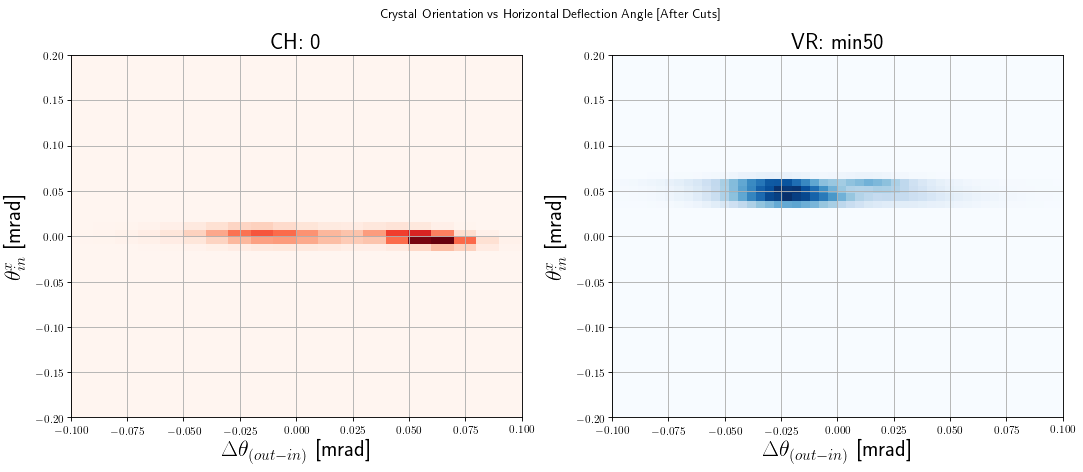

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Crystal Orientation vs Horizontal Deflection Angle [After Cuts]")
plotR=plot2D(axes[0],dataset["deltaTheta"],dataset["thetaIn_x"]-dataset["deltaGonio"],
       dtL,tInXL,(nBth,nBthF),
#       [[-.1,.1],[dataset.iloc[0]["gonio_angle"]-max_thetaInx-thetaInx_bias,dataset.iloc[0]["gonio_angle"]+max_thetaInx-thetaInx_bias]],
       [[-.1,.1],tOutXR],
       "Reds")
print(tOutXGonioR)
plotR.set_title(inFileLabel,fontsize=20)
plotR.grid(True)
plotB= plot2D(axes[1],datasetSimu["deltaTheta"],datasetSimu["thetaIn_x"]-datasetSimu["deltaGonio"],
       dtL,tInXL,(nBthF,nBthF),
       [[-.1,.1],tOutXR],
       "Blues")
plotB.set_title(inSimFileLabel,fontsize=20)
plotB.grid(True)
print(tOutXR)


plt.show()

## Now let's mimic the effect of a magnetic septum that cleans the channeled beam

In [13]:
#mimic the presence of the septum
septumFlag = False
septumAng = 0.03 #I want the particle to be deflected of more than 30urad (2ThetaC, 1/2 ThetaBending)
thetaDeflection = 0.061 #this is the deflection angle
thetaAcceptance = 0.030 #this is an angular acceptance around the deflection angle
if septumFlag:
#    dataseptum = dataset[(dataset.thetaOut_x)>septumAng]
     dataseptum = dataset[abs(dataset["thetaOut_x"]-dataset["deltaGonio"]-thetaDeflection)<thetaAcceptance]
else:
    dataseptum = dataset

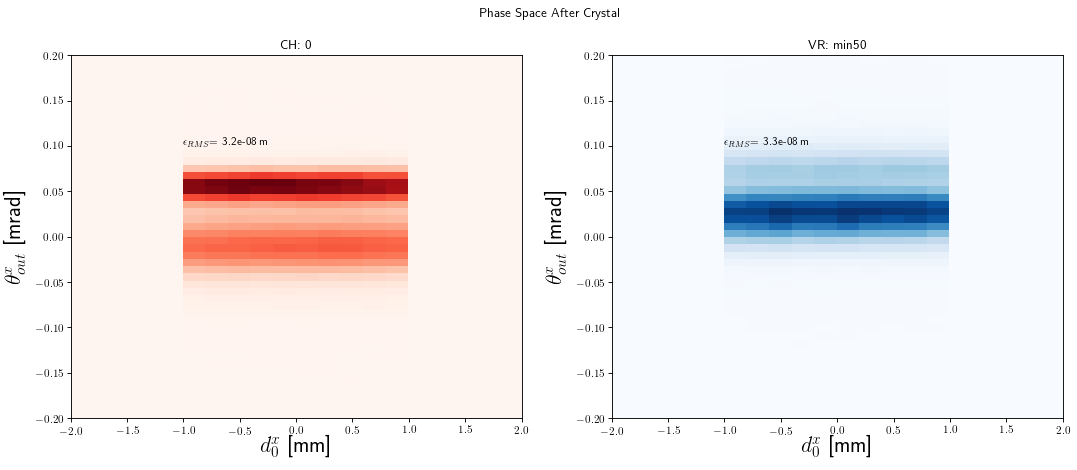

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Phase Space After Crystal")
plotR=plot2D(axes[0],dataseptum["d0_x"],dataseptum["thetaOut_x"]-dataseptum["deltaGonio"],
       d0xL,tOutXL,(nBd0,nBthF),
       [d0xR, tOutXR],"Reds")
plotR.set_title(inFileLabel)
plotR.text(-1.,0.1,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(dataseptum["d0_x"],dataseptum["thetaOut_x"]+dataseptum["gonio_angle"])))



plotB=plot2D(axes[1],datasetSimu["d0_x"],datasetSimu["thetaOut_x"]-datasetSimu["deltaGonio"],
       d0xL,tOutXL,(nBd0,nBthF),
       [d0xR, tOutXR],"Blues")

plotB.set_title(inSimFileLabel)
plotB.text(-1.,0.1,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"])))


plt.show()

fig.savefig("beams.png")

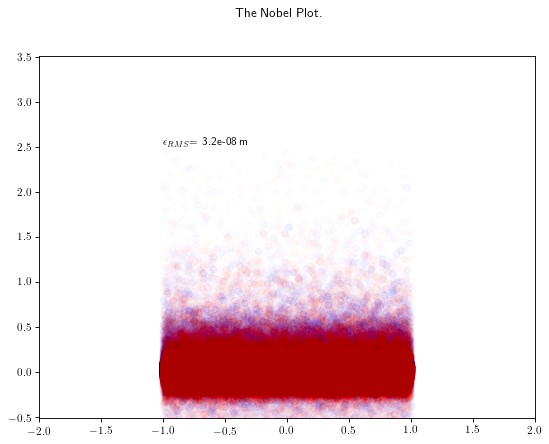

Emittance (RMS):  0.03246912185047184


In [15]:
merged = dataseptum
merged.append(datasetSimu)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("The Nobel Plot.")

deltaRange = 0.5
# VR plot
plt.plot(datasetSimu["d0_x"],datasetSimu["thetaOut_x"]-datasetSimu["deltaGonio"], 'o', c="b", alpha=0.01)
plt.xlim(-2,2)
plt.ylim((1-deltaRange)*np.min(datasetSimu["thetaOut_x"]-datasetSimu["deltaGonio"]),(1+deltaRange)*np.max(datasetSimu["thetaOut_x"]-datasetSimu["deltaGonio"]))
#CH plot
plt.plot(dataseptum["d0_x"],dataseptum["thetaOut_x"]-dataseptum["deltaGonio"], 'o', c="r", alpha=0.01)
plt.xlim(-2,2)
plt.ylim((1-deltaRange)*np.min(dataset["thetaOut_x"]-dataset["deltaGonio"]),(1+deltaRange)*np.max(dataset["thetaOut_x"]-dataset["deltaGonio"]))



plt.text(-1.,2.5,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(merged["d0_x"],merged["thetaOut_x"]-merged["deltaGonio"])))
plt.show()

print("Emittance (RMS): ",emittanceRMS(merged["d0_x"],merged["thetaOut_x"]-merged["deltaGonio"]))


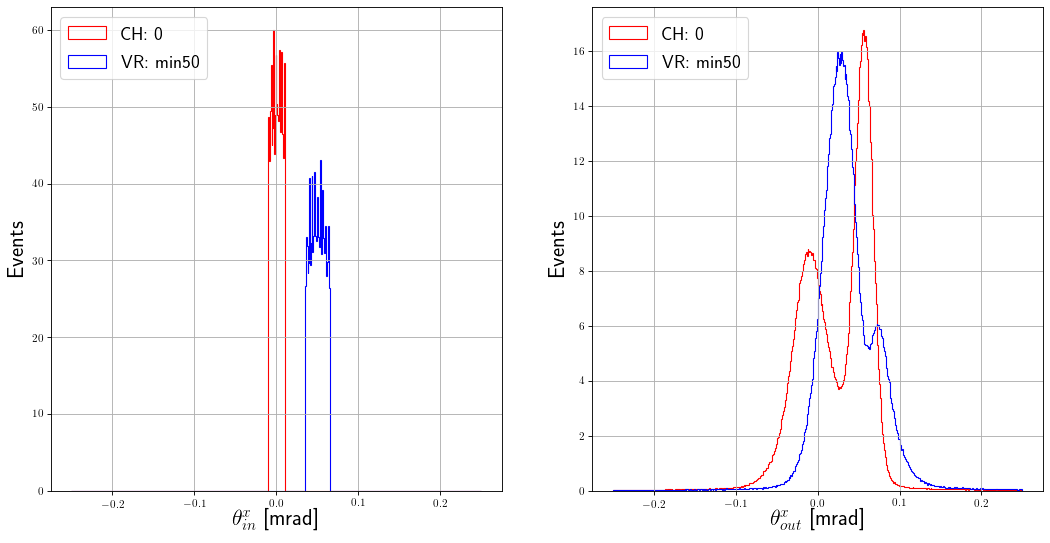

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 40
    # variables        = 3
    chi-square         = 4.0419e+11
    reduced chi-square = 1.0924e+10
    Akaike info crit   = 927.451122
    Bayesian info crit = 932.517760
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  767.416445 (init = 1)
    center:     0.02099275 (init = 0)
    sigma:      1.2689e-04 (init = 1)
    fwhm:       2.9879e-04 == '2.3548200*sigma'
    height:     2412827.96 == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 200
    # variables        = 3
    chi-square         = 6.9933e+08
    reduced chi-square = 3549907.53
    Akaike info crit   = 3019.46369
    Bayesian info crit = 3029.35865
[[Variables]]
    amplitude:  1316.30111 +/- 21.5465192 (1.64%) (i

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 8),dpi=80,facecolor='w', edgecolor='k')

commonBinWidth=0.001

plot1DNorm(ax[0],dataseptum["thetaIn_x"]-dataseptum["deltaGonio"],inFileLabel,tInXL,"Events",
        False,'r',int(0.5/commonBinWidth),[-0.25,0.25])
plot1DNorm(ax[0],datasetSimu["thetaIn_x"]-datasetSimu["deltaGonio"],inSimFileLabel,tInXL,"Events",
        False,'b',int(0.5/commonBinWidth),[-0.25,0.25])
ax[0].legend(loc="upper left", fontsize=17)

plot1DNorm(ax[1],dataseptum["thetaOut_x"]-dataseptum["deltaGonio"],inFileLabel,tOutXL,"Events",
        False,'r',int(0.5/commonBinWidth),[-0.25,0.25])
plot1DNorm(ax[1],datasetSimu["thetaOut_x"]-datasetSimu["deltaGonio"],inSimFileLabel,tOutXL,"Events",
        False,'b',int(0.5/commonBinWidth),[-0.25,0.25])
ax[1].legend(loc="upper left", fontsize=17)

if True:
    from lmfit.models import GaussianModel

    mod = GaussianModel()
    modSimu = GaussianModel()

#    mod.set_param_hint('sigma', min=0, max=0.018, value = 0.016, vary = True)
#    mod.set_param_hint('amplitude', min=1000, value = 2200)
#    mod.set_param_hint('center', min=0.056, max=0.1, value = 0.06, vary = True)

    data_entries, bins = np.histogram(dataseptum["thetaOut_x"]-dataseptum["deltaGonio"], bins=int(0.04/commonBinWidth))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    pars = mod.guess(data_entries, x=data_entries)
    out = mod.fit(data_entries.astype(float), x=binscenters.astype(float))
    predicted = out.eval(x=np.linspace(-.3, .3, 1000))
#    plt.plot(np.linspace(-.3, .3, 1000), predicted, 'k--', label=(r"$\epsilon_{{CH}}$={:.3f}, $\mu$={:.1e}, $\sigma$={:.1e}".format(((out.params['amplitude'].value)/commonBinWidth/(len(dataset["deltaTheta"]))), out.params['center'].value, out.params['sigma'].value)))

    plt.grid(True)
   # plt.show()
    
#    data_entriesSimu, binsSimu = np.histogram(datasetSimu[abs(datasetSimu.deltaTheta)<0.1]["deltaTheta"], bins=int(0.2/commonBinWidth))
#    binscentersSimu = np.array([0.5 * (binsSimu[i] + binsSimu[i+1]) for i in range(len(binsSimu)-1)])
#    parsSimu = modSimu.guess(data_entriesSimu, x=data_entriesSimu)
#    outSimu = modSimu.fit(data_entriesSimu.astype(float), x=binscentersSimu.astype(float))
#    plt.xlim(-.15, .15)
   
#    plt.plot(binscentersSimu, outSimu.best_fit, 'k-.', label=(r"$\epsilon_{{VR}}$={:.3f}, $\mu$={:.1e}, $\sigma$={:.1e}".format(((outSimu.params['amplitude'].value)/commonBinWidth/(len(datasetSimu["deltaTheta"]))), outSimu.params['center'].value, outSimu.params['sigma'].value)))

    plt.grid(True)
    plt.legend(loc="upper left", fontsize=17)
    plt.show()
    fig.savefig("InAndOut_"+inFileLabel.split(": ")[1]+"_"+inSimFileLabel.split(": ")[1]+".png")
            


    print(out.fit_report())
    print(outSimu.fit_report())





merged = dataset
merged.append(datasetSimu)

print((dataset["d0_x"].shape,dataset["d0_x"]))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plt.hist2d(np.array([dataset["d0_x"],dataset["d0_x"]]),
           np.array([dataset["thetaOut_x"]+dataset["gonio_angle"],dataset["thetaOut_x"]+dataset["gonio_angle"]]),label=['a','b'])

#    ax.set_xlabel(xlabel, fontsize='20')
#    ax.set_ylabel(ylabel, fontsize='20')
#plot2D(ax,dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
#plot2D(ax,datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Blues")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plot2D(ax,merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"],
       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
plt.title("Recombined beam",fontsize=20)

plt.show()

print("Emittance (RMS): ",emittanceRMS(merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"]))


## Let's merge the two phase spaces

merged = dataset
merged.append(datasetSimu)

print((dataset["d0_x"].shape,dataset["d0_x"]))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plt.hist2d(np.array([dataset["d0_x"],dataset["d0_x"]]),
           np.array([dataset["thetaOut_x"]+dataset["gonio_angle"],dataset["thetaOut_x"]+dataset["gonio_angle"]]),label=['a','b'])

#    ax.set_xlabel(xlabel, fontsize='20')
#    ax.set_ylabel(ylabel, fontsize='20')
#plot2D(ax,dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
#plot2D(ax,datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Blues")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plot2D(ax,merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"],
       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
plt.title("Recombined beam",fontsize=20)

plt.show()

print("Emittance (RMS): ",emittanceRMS(merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"]))
